Setup

In [ ]:
!apt-get install p7zip-full
!7z x /content/archive-4.zip -o/content/


Step 1: Extract and Save Individual Word Audio Files

In [31]:
import scipy.io.wavfile as wav
import numpy as np
import torchaudio
import os
all_word_paths = {}  # word -> list of (path, speaker)

# Checking if TIMIT_DIR exists
if not os.path.exists("/content/archive-4"):
    print(f"{archive-4} does not exist!")
else:
    print("Listing files in archive-4:")
    for root, dirs, files in os.walk("/content/archive-4"):
        print(f"Found files in {root}: {files[:5]}")

# Processing WRD files and extracting word audio
for root, _, files in os.walk("/content/archive-4"):
    for file in files:
        if file.endswith(".WRD"):
            wrd_path = os.path.join(root, file)
            wav_path = wrd_path.replace(".WRD", ".WAV")
            speaker_id = os.path.basename(os.path.dirname(wrd_path))
            utt_id = os.path.splitext(file)[0]

            try:
                waveform, sr = torchaudio.load(wav_path)
            except Exception as e:
                print(f"Failed to load {wav_path}: {e}")
                continue

            audio = waveform.squeeze().numpy()

            with open(wrd_path, 'r') as f:
                for i, line in enumerate(f):
                    start, end, word = line.strip().split()
                    start, end = int(start), int(end)
                    word_audio = audio[start:end]

                    word_dir = os.path.join("/content/word_dir", word)
                    os.makedirs(word_dir, exist_ok=True)
                    file_name = f"{speaker_id}_{utt_id}_{i}.wav"
                    word_file = os.path.join(word_dir, file_name)
                    wav.write(word_file, sr, word_audio)

                    all_word_paths.setdefault(word, []).append((word_file, speaker_id))

print(f"Extracted words: {len(all_word_paths)} unique words.")


Listing files in archive-4:
Found files in /content/archive-4: ['TIMITDIC.TXT', 'SPKRINFO.TXT', 'SPKRSENT.TXT', 'PROMPTS.TXT', 'TIMITDIC.DOC']
Found files in /content/archive-4/data: []
Found files in /content/archive-4/data/TEST: []
Found files in /content/archive-4/data/TEST/DR1: []
Found files in /content/archive-4/data/TEST/DR1/FDAC1: ['SA1.WRD', 'SX124.WAV.wav', 'SX124.WAV', 'SX394.PHN', 'SX34.WAV']
Found files in /content/archive-4/data/TEST/DR1/MSTK0: ['SA1.WRD', 'SX124.WAV.wav', 'SX124.WAV', 'SX394.PHN', 'SI2222.PHN']
Found files in /content/archive-4/data/TEST/DR1/FJEM0: ['SA1.WRD', 'SX184.WAV.wav', 'SX94.WAV.wav', 'SA2.TXT', 'SX4.TXT']
Found files in /content/archive-4/data/TEST/DR1/FAKS0: ['SA1.WRD', 'SI1573.WAV', 'SX403.TXT', 'SX313.WRD', 'SX403.WAV.wav']
Found files in /content/archive-4/data/TEST/DR1/MWBT0: ['SX203.WAV', 'SA1.WRD', 'SX113.PHN', 'SA2.TXT', 'SI1553.PHN']
Found files in /content/archive-4/data/TEST/DR1/FELC0: ['SA1.WRD', 'SX396.WAV.wav', 'SA2.TXT', 'SX36.PHN

In [32]:
import pandas as pd
import random

pairs = []
random.seed(42)

num_positive = 3000
num_negative = 3000
max_pairs_per_word = 3
words_for_sampling = random.sample(list(all_word_paths.keys()), min(2000, len(all_word_paths)))

# Positive pairs
pos_count = 0
for word in words_for_sampling:
    samples = all_word_paths[word]
    if len(samples) < 2:
        continue

    sampled_pairs = 0
    attempts = 0
    while sampled_pairs < max_pairs_per_word and attempts < 8:
        a, b = random.sample(samples, 2)
        if a[1] != b[1]:  # different speakers
            pairs.append((a[0], b[0], 1))
            sampled_pairs += 1
            pos_count += 1
        attempts += 1

    if pos_count >= num_positive:
        break

print(f"✅ Positive pairs created: {pos_count}")

# Negative pairs
if len(words_for_sampling) < 2:
    print("Not enough unique words to generate negative pairs.")
else:
    neg_count = 0
    while neg_count < num_negative:
        w1, w2 = random.sample(words_for_sampling, 2)
        if w1 == w2: continue
        a = random.choice(all_word_paths[w1])
        b = random.choice(all_word_paths[w2])
        pairs.append((a[0], b[0], 0))
        neg_count += 1
        if neg_count % 100 == 0:
            print(f"{neg_count} negative pairs added.")

    print(f"✅ Negative pairs created: {neg_count}")


✅ Positive pairs created: 2847
100 negative pairs added.
200 negative pairs added.
300 negative pairs added.
400 negative pairs added.
500 negative pairs added.
600 negative pairs added.
700 negative pairs added.
800 negative pairs added.
900 negative pairs added.
1000 negative pairs added.
1100 negative pairs added.
1200 negative pairs added.
1300 negative pairs added.
1400 negative pairs added.
1500 negative pairs added.
1600 negative pairs added.
1700 negative pairs added.
1800 negative pairs added.
1900 negative pairs added.
2000 negative pairs added.
2100 negative pairs added.
2200 negative pairs added.
2300 negative pairs added.
2400 negative pairs added.
2500 negative pairs added.
2600 negative pairs added.
2700 negative pairs added.
2800 negative pairs added.
2900 negative pairs added.
3000 negative pairs added.
✅ Negative pairs created: 3000


In [33]:
df = pd.DataFrame(pairs, columns=["audio1", "audio2", "label"])
csv_path = "/content/siamese_.csv"
df.to_csv(csv_path, index=False)
print("📁 CSV saved to:", csv_path)


📁 CSV saved to: /content/siamese_.csv


In [34]:
import torch
import torchaudio
import librosa
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import accuracy_score
import pandas as pd
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from scipy.spatial.distance import euclidean

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAMPLE_RATE = 16000

# Load Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model_wav2vec = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-base-960h", output_hidden_states=True
).to(device)
model_wav2vec.eval()

class Wav2Vec2SiameseDataset(Dataset):
    def __init__(self, df, sample_rate=16000):
        self.df = df
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.df)

    def _load_audio(self, path):
        audio, sr = librosa.load(path, sr=self.sample_rate)
        target_length = 16000
        if len(audio) < target_length:
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        return torch.tensor(audio, dtype=torch.float32)

    def _extract_middle_embedding(self, audio_tensor):
        with torch.no_grad():
            inputs = processor(audio_tensor, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.get("attention_mask", None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

            outputs = model_wav2vec(input_values, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states[6]
            embedding = hidden_states.mean(dim=1)
            return embedding.squeeze(0).cpu()

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio1 = self._load_audio(row["audio1"])
        audio2 = self._load_audio(row["audio2"])
        label = torch.tensor(row["label"], dtype=torch.float32)

        emb1 = self._extract_middle_embedding(audio1)
        emb2 = self._extract_middle_embedding(audio2)

        return emb1, emb2, label


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

    def set_temperature(self, logits, labels):
        self.eval()
        nll_criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        labels = labels.float()

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(logits / self.temperature, labels)
            loss.backward()
            return loss

        optimizer.step(eval)


In [36]:
scaled_logits = temp_scaler(logits)
scaled_probs = torch.sigmoid(scaled_logits)


In [37]:
class MLPDistanceClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        f1 = self.encoder(x1)
        f2 = self.encoder(x2)
        dist = torch.norm(f1 - f2, p=2, dim=1)
        diff = torch.abs(f1 - f2)
        similarity_score = self.classifier(diff)
        return similarity_score, dist

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature


In [38]:
# Load Data
full_df = pd.read_csv("/content/siamese_.csv")
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

train_dataset = Wav2Vec2SiameseDataset(train_df)
test_dataset = Wav2Vec2SiameseDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train Setup
model = MLPDistanceClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
for epoch in range(5):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        emb1, emb2, labels = batch
        emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)

        logits, _ = model(emb1, emb2)
        loss = criterion(logits.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Train Loss: 0.3871
Epoch 2, Train Loss: 0.0930
Epoch 3, Train Loss: 0.0352
Epoch 4, Train Loss: 0.0121
Epoch 5, Train Loss: 0.0028


In [39]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Evaluation code:
def evaluate(model, data_loader, temp_scaler=None):
    model.eval()
    if temp_scaler:
        temp_scaler.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            emb1, emb2, labels = batch
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)

            logits, _ = model(emb1, emb2)
            logits = logits.view(-1)

            if temp_scaler:
                logits = temp_scaler(logits)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, f1, all_probs


In [40]:
import torch
import torchaudio
import numpy as np


class TemperatureScaler(torch.nn.Module):
    def __init__(self, temperature=1.0):
        super(TemperatureScaler, self).__init__()
        self.temperature = temperature

    def forward(self, logits):
        return logits / self.temperature

temp_scaler = TemperatureScaler(temperature=2.0)

def predict_pair2(model, path1, path2, processor, model_wav2vec, temp_scaler, sample_rate=16000, threshold=0.5):
    model.eval()

    def extract_embedding(filepath):
        waveform, sr = torchaudio.load(filepath)
        if sr != sample_rate:
            resampler = torchaudio.transforms.Resample(sr, sample_rate)
            waveform = resampler(waveform)
        with torch.no_grad():
            inputs = processor(waveform.squeeze(0), sampling_rate=sample_rate, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.get("attention_mask", None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)
            outputs = model_wav2vec(input_values, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states[6]
            return hidden_states.mean(dim=1)

    emb1 = extract_embedding(path1).to(device)
    emb2 = extract_embedding(path2).to(device)

    # Load raw waveform to calculate mismatch frame
    waveform1, _ = torchaudio.load(path1)
    waveform2, _ = torchaudio.load(path2)
    min_len = min(waveform1.size(1), waveform2.size(1))
    waveform1 = waveform1[:, :min_len]
    waveform2 = waveform2[:, :min_len]

    emb1_frames = processor(waveform1.squeeze(0), sampling_rate=sample_rate, return_tensors="pt", padding=True).input_values.to(device)
    emb2_frames = processor(waveform2.squeeze(0), sampling_rate=sample_rate, return_tensors="pt", padding=True).input_values.to(device)

    first_mismatch_frame = None
    for i in range(emb1_frames.size(1)):
        frame1 = emb1_frames[:, i].detach().cpu().numpy()
        frame2 = emb2_frames[:, i].detach().cpu().numpy()
        dist = np.linalg.norm(frame1 - frame2)

        if dist > threshold:
            first_mismatch_frame = i
            break

    # Final prediction and confidence
    with torch.no_grad():
        logits = model(emb1, emb2)
        if isinstance(logits, tuple):
            logits = logits[0]
        logits = logits.view(-1)
        logits = temp_scaler(logits)
        prob = torch.sigmoid(logits).item()
        pred = int(prob > 0.5)

        if pred == 0 and first_mismatch_frame is not None:
            print(f"First mismatch at frame {first_mismatch_frame} with distance: {dist:.4f}")
            print(f"Approx mismatch time: {first_mismatch_frame / sample_rate:.2f} seconds")

        print(f"Prediction: {pred} (Same=1, Diff=0), Calibrated Confidence: {prob:.4f}")

    return first_mismatch_frame


In [41]:

acc, f1, probs = evaluate(model, test_loader, temp_scaler=temp_scaler)



Accuracy: 0.9581
F1 Score: 0.9597


Test own audios

In [42]:
predict_pair2(
    model=model,
    path1="/content/zero.wav",
    path2="/content/zero 2.wav",
    processor=processor,
    model_wav2vec=model_wav2vec,
    temp_scaler=temp_scaler
)

Prediction: 1 (Same=1, Diff=0), Calibrated Confidence: 0.8695


9395

In [46]:
predict_pair2(
    model=model,
    path1="/content/respect.wav",
    path2="/content/Resent.wav",
    processor=processor,
    model_wav2vec=model_wav2vec,
    temp_scaler=temp_scaler
)

First mismatch at frame 6422 with distance: 0.5069
Approx mismatch time: 0.40 seconds
Prediction: 0 (Same=1, Diff=0), Calibrated Confidence: 0.1824


6422

In [51]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ECE Calculation
def compute_ece(probs, labels, n_bins=10):
    """Expected Calibration Error"""
    probs = np.array(probs)
    labels = np.array(labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        start, end = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (probs >= start) & (probs < end) if i < n_bins - 1 else (probs >= start) & (probs <= end)
        bin_size = np.sum(mask)

        if bin_size > 0:
            bin_confidence = np.mean(probs[mask])
            bin_accuracy = np.mean(labels[mask])
            ece += (bin_size / len(probs)) * abs(bin_confidence - bin_accuracy)

    return ece

#  Reliability Diagram
def plot_reliability_diagram(probs, labels, n_bins=10, title="Reliability Diagram"):
    probs = np.array(probs)
    labels = np.array(labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2

    accuracies = []
    confidences = []
    fig = plt.figure()
    for i in range(n_bins):
        start, end = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (probs >= start) & (probs < end) if i < n_bins - 1 else (probs >= start) & (probs <= end)
        bin_size = np.sum(mask)

        if bin_size > 0:
            bin_conf = np.mean(probs[mask])
            bin_acc = np.mean(labels[mask])
        else:
            bin_conf = 0.0
            bin_acc = 0.0

        confidences.append(bin_conf)
        accuracies.append(bin_acc)

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.plot(confidences, accuracies, marker='o', label='Model Calibration')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    return fig

ECE Before Temp Scaling: 0.0239
ECE After Temp Scaling:  0.0194


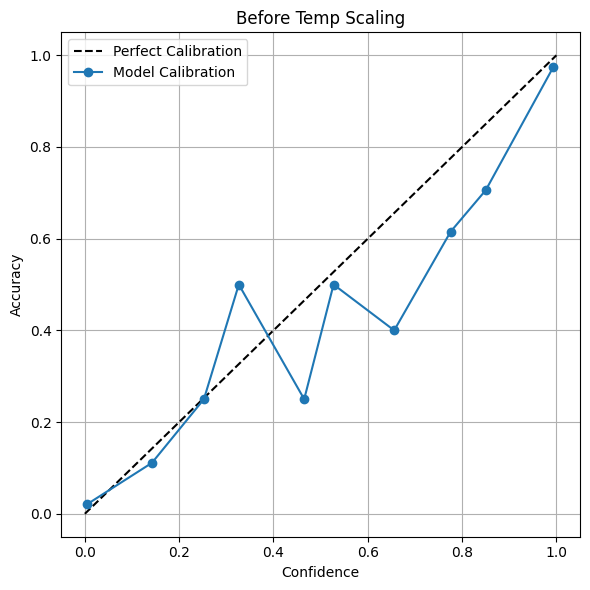

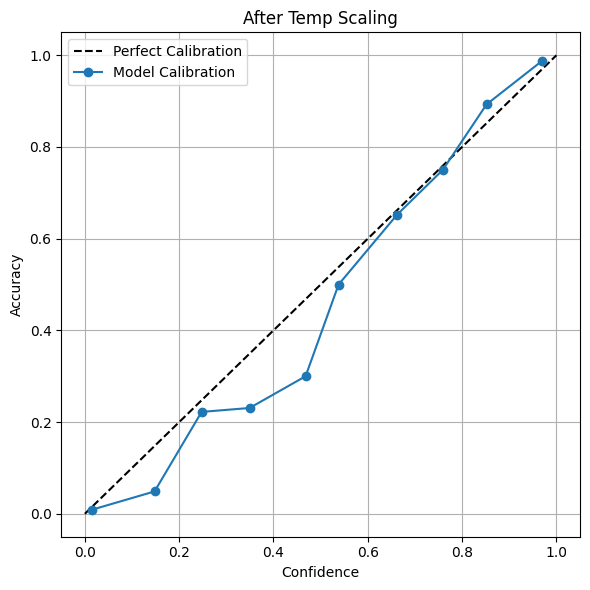

In [52]:

raw_logits = []
scaled_logits = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        emb1, emb2, y = batch
        emb1, emb2, y = emb1.to(device), emb2.to(device), y.to(device)

        logits = model(emb1, emb2)
        if isinstance(logits, tuple):
            logits = logits[0]
        logits = logits.view(-1)

        raw_logits.extend(logits.cpu().numpy())  # Before temp scaling
        scaled = temp_scaler(logits)             # After temp scaling
        scaled_logits.extend(scaled.cpu().numpy())
        labels.extend(y.cpu().numpy())

# Convert to probabilities
raw_probs = torch.sigmoid(torch.tensor(raw_logits)).numpy()
scaled_probs = torch.sigmoid(torch.tensor(scaled_logits)).numpy()
labels = np.array(labels)

# Compute ECE
ece_before = compute_ece(raw_probs, labels)
ece_after = compute_ece(scaled_probs, labels)

print(f"ECE Before Temp Scaling: {ece_before:.4f}")
print(f"ECE After Temp Scaling:  {ece_after:.4f}")

# Plotting
fig = plot_reliability_diagram(raw_probs, labels, title="Before Temp Scaling")
fig.savefig("reliability_before_temp_scaling.png", bbox_inches='tight')
plt.close(fig)

fig = plot_reliability_diagram(scaled_probs, labels, title="After Temp Scaling")
fig.savefig("reliability_after_temp_scaling.png", bbox_inches='tight')
plt.close(fig)


